In [1]:
# Core numerical and data libraries
import numpy as np
import pandas as pd

# Database connection
from sqlalchemy import create_engine


In [2]:
# Database credentials
# NOTE: Credentials will be externalized in Week-4
DB_USER = "root"
DB_PASSWORD = "1433"
DB_HOST = "localhost"
DB_NAME = "financial_analytics"

# Create MySQL engine
engine = create_engine(
    f"mysql+mysqlconnector://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}"
)


In [3]:
# Load adjusted prices from database
query = """
SELECT asset_id, trade_date, adj_close
FROM market_prices
ORDER BY asset_id, trade_date
"""

df = pd.read_sql(query, engine)

# Convert trade_date to datetime
df["trade_date"] = pd.to_datetime(df["trade_date"])

df.head()


,asset_id,trade_date,adj_close
0,1,2019-01-02,37.538822
1,1,2019-01-03,33.799679
2,1,2019-01-04,35.242561
3,1,2019-01-07,35.164124
4,1,2019-01-08,35.834446


In [4]:
# Calculate daily log returns for Monte Carlo input
df["log_return"] = (
    df
    .groupby("asset_id")["adj_close"]
    .transform(lambda x: np.log(x / x.shift(1)))
)

# Drop initial NaN returns
returns_df = df.dropna(subset=["log_return"])

returns_df.head()


,asset_id,trade_date,adj_close,log_return
1,1,2019-01-03,33.799679,-0.104924
2,1,2019-01-04,35.242561,0.041803
3,1,2019-01-07,35.164124,-0.002228
4,1,2019-01-08,35.834446,0.018883
5,1,2019-01-09,36.442982,0.016839


In [5]:
# Create returns matrix
# Rows: dates, Columns: assets
returns_matrix = (
    returns_df
    .pivot(index="trade_date", columns="asset_id", values="log_return")
)

returns_matrix.head()


asset_id,1,2,3,4,5,6,7,8,9,10,11
trade_date,,,,,,,,,,,
2019-01-03,-0.104924,-0.037482,-0.014314,-0.016156,-0.015473,-0.007036,-0.016018,-0.031978,-0.005156,0.003564,-0.025068
2019-01-04,0.041803,0.045460,0.036203,0.040692,0.036206,0.020205,0.016644,0.056094,0.006227,0.002487,0.033759
2019-01-07,-0.002228,0.001274,0.000695,-0.000782,0.005186,-0.004008,-0.006435,0.052935,0.011703,0.006367,0.006986
2019-01-08,0.018883,0.007225,-0.001887,-0.001958,0.007245,0.003684,0.022961,0.001164,0.006957,0.028846,0.009649
2019-01-09,0.016839,0.014198,-0.001692,0.009752,0.005261,-0.016466,-0.007957,0.009438,-0.003261,-0.012663,0.004090


In [6]:
# Mean daily returns per asset
mean_returns = returns_matrix.mean()

# Covariance matrix of returns
cov_matrix = returns_matrix.cov()

mean_returns, cov_matrix


(asset_id
 1     0.001065
 2     0.000873
 3     0.000741
 4     0.000511
 5     0.000551
 6     0.000365
 7     0.000413
 8     0.001715
 9     0.000818
 10    0.000025
 11    0.000569
 dtype: float64,
 asset_id        1         2         3         4         5         6   \
 asset_id                                                               
 1         0.000381  0.000244  0.000156  0.000175  0.000116  0.000092   
 2         0.000244  0.000318  0.000144  0.000156  0.000086  0.000085   
 3         0.000156  0.000144  0.000353  0.000343  0.000202  0.000076   
 4         0.000175  0.000156  0.000343  0.000431  0.000233  0.000085   
 5         0.000116  0.000086  0.000202  0.000233  0.000386  0.000055   
 6         0.000092  0.000085  0.000076  0.000085  0.000055  0.000160   
 7         0.000075  0.000064  0.000079  0.000084  0.000066  0.000084   
 8         0.000379  0.000317  0.000229  0.000253  0.000128  0.000046   
 9         0.000095  0.000089  0.000068  0.000078  0.000047  0.0000

In [7]:
# Check dimensions
print("Number of assets:", mean_returns.shape[0])
print("Covariance matrix shape:", cov_matrix.shape)


Number of assets: 11
Covariance matrix shape: (11, 11)


In [9]:
# Monte Carlo simulation parameters
num_simulations = 10_000     # Number of simulated paths
time_horizon = 252           # Trading days in 1 year
num_assets = mean_returns.shape[0]

# Equal-weighted portfolio
weights = np.array([1 / num_assets] * num_assets)


In [10]:
# Generate correlated random returns using multivariate normal distribution
# Shape: (time_horizon, num_assets, num_simulations)

simulated_returns = np.random.multivariate_normal(
    mean_returns,
    cov_matrix,
    size=(time_horizon, num_simulations)
)


In [11]:
simulated_returns.shape


(252, 10000, 11)

In [12]:
# Calculate daily portfolio returns for each simulation
# Dot product applies portfolio weights

portfolio_simulated_returns = np.dot(
    simulated_returns,
    weights
)


In [13]:
# Initialize portfolio value paths
initial_portfolio_value = 1.0

# Convert log returns to cumulative portfolio value
portfolio_value_paths = np.exp(
    np.cumsum(portfolio_simulated_returns, axis=0)
) * initial_portfolio_value

portfolio_value_paths.shape


(252, 10000)

In [15]:
# Convert final portfolio values to pandas Series for easy statistics
final_portfolio_values_series = pd.Series(final_portfolio_values)

# Descriptive statistics of final portfolio values
final_portfolio_values_series.describe()


count    10000.000000
mean         1.210660
std          0.231476
min          0.554651
25%          1.047889
50%          1.186206
75%          1.353195
max          2.384078
dtype: float64

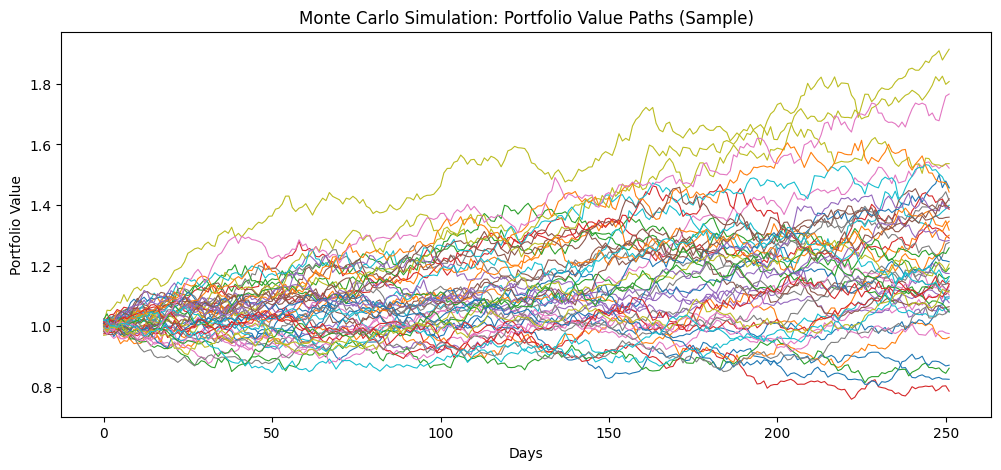

In [16]:
import matplotlib.pyplot as plt

# Plot first 50 simulation paths for visual sanity check
plt.figure(figsize=(12, 5))
plt.plot(portfolio_value_paths[:, :50], linewidth=0.8)
plt.title("Monte Carlo Simulation: Portfolio Value Paths (Sample)")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.show()


In [18]:
# Convert final portfolio values to total returns
# Return = (Final Value - Initial Value) / Initial Value

final_returns = (
    final_portfolio_values - initial_portfolio_value
) / initial_portfolio_value

# Convert NumPy array to pandas Series for easier analysis
final_returns = pd.Series(final_returns, name="final_return")

# Summary statistics
final_returns.describe()


count    10000.000000
mean         0.210660
std          0.231476
min         -0.445349
25%          0.047889
50%          0.186206
75%          0.353195
max          1.384078
Name: final_return, dtype: float64

In [19]:
# Calculate Value at Risk (VaR)
# Using historical simulation from Monte Carlo output

var_95 = np.percentile(final_returns, 5)   # 95% confidence
var_99 = np.percentile(final_returns, 1)   # 99% confidence

var_95, var_99


(np.float64(-0.13256533096600182), np.float64(-0.23903845564086196))

In [20]:
# Worst-case (minimum) portfolio return
worst_case_return = final_returns.min()

worst_case_return


np.float64(-0.4453486433600311)

In [21]:
# Probability that portfolio ends with a loss
probability_of_loss = (final_returns < 0).mean()

probability_of_loss


np.float64(0.18)

In [22]:
# Create risk summary table
risk_summary = pd.DataFrame({
    "Metric": [
        "VaR (95%)",
        "VaR (99%)",
        "Worst Case Return",
        "Probability of Loss"
    ],
    "Value": [
        var_95,
        var_99,
        worst_case_return,
        probability_of_loss
    ]
})

risk_summary


,Metric,Value
0,VaR (95%),-0.132565
1,VaR (99%),-0.239038
2,Worst Case Return,-0.445349
3,Probability of Loss,0.180000


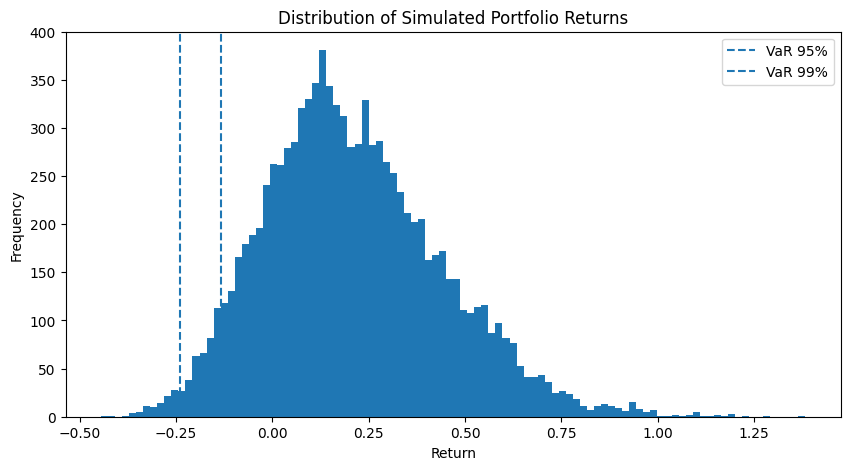

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(final_returns, bins=100)
plt.axvline(var_95, linestyle="--", label="VaR 95%")
plt.axvline(var_99, linestyle="--", label="VaR 99%")
plt.title("Distribution of Simulated Portfolio Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()
